<a href="https://colab.research.google.com/github/JoeL-8883/DL-Assignment/blob/optical_flow/DL_coursework_2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning Coursework 2025

# Joe Lee - 2557699L

## Action classification

## Getting the data

In [66]:
download = False
if download:
    !gdown --id 1QVK62Szl7-IxstMns34Q9VGeVbM4sgjB
    !unzip dataset.zip

### Load the data (including preprocessng)

The first step in preprocessing involved converting videos to grayscale, reducing input to single-channel tensors. This lowered memory usage and improved training and inference times without compromising performance, as color is not essential for classifying actions based on the spatiotemporal dynamics of joint movements using a CNN.

To improve generalization, I applied data augmentation through random horizontal flips. I also make the dataset larger by making $k=5$ subsequences of each video.

Initial experiments with a CNN+LSTM architecture on grayscale videos yielded moderate results. Due to compute limitations, I aimed to avoid increasing model complexity and instead focused on enhancing preprocessing. I explored optical flow, which effectively captures motion dynamics. While optical flow images can appear noisy and obscure fine-grained distinctions (e.g., between walking and skipping), visual inspection revealed noticeable motion differences.

When inspecting results of optical flow computations, I found that the data was noisy, to reduce this noise, I blurred and darkened the background of each frame, which yielded a much cleaner signal. I tried normalising this optical flow data, however after visualising this would also introduce noise into the data.

In [ ]:
import matplotlib.pyplot as plt
from torchvision.io import read_video, write_video
from torch.utils.data import Dataset, DataLoader
import os
import torch
from torchvision.transforms.functional import rgb_to_grayscale
import numpy as np
import cv2
import time

class BuildDataset(Dataset):
    def __init__(self, dataset_dir, n_subsequences=5):
        self.dataset_dir = dataset_dir
        self.data = [] # store data as (video, label) pairs
        self.flag = False
        self.classes = {
            'walk': 0,
            'run': 1,
            'jump': 2,
            'side': 3,
            'bend': 4,
            'wave1': 5,
            'wave2': 6,
            'pjump': 7,
            'jack': 8,
            'skip': 9
        }

        '''Populate the dataset'''
        for action in os.listdir(dataset_dir):
            action_dir = os.path.join(dataset_dir, action)
            for video in os.listdir(action_dir):
                video_dir = os.path.join(action_dir, video)
                video, _, info = read_video(video_dir)

                # Subsequence video
                for i in range(n_subsequences):
                    subsequence = self.subsequence_video(video)
                    self.data.append((subsequence, self.classes[action]))
                self.data.append((video, self.classes[action]))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        video, label = self.data[idx]
        length = video.shape[0]

        video = self.convert_bw(video)
        video = self.crop_image(video)

        if np.random.rand() < 0.5:
            video = self.flip_video(video)
            
        video = self.calculate_optical_flow(video)


        return video, label, length

    def convert_bw(self, video):
        video_tensor = video
        gray_frames = []

        '''Convert each frame to grayscale'''
        for frame in video_tensor:
            frame = frame.permute(2, 0, 1) # rearrange tensor to (channels, height, width)
            gray = rgb_to_grayscale(frame, num_output_channels=1)
            gray_frames.append(gray)

        gray_video = torch.stack(gray_frames)
        gray_video = gray_video.permute(0, 2, 3, 1) # convert back to (num_frames, height, width, channels)
        gray_video = gray_video.squeeze(-1) # remove the last channel
        return gray_video

    # Crop to 128 x 128
    def crop_image(self, frame):
        _, h, w = frame.shape

        # Get the top left corner
        top = (h - 128) // 2
        left = (w - 128) // 2

        return frame[:, top:top+128, left:left+128]

    def flip_video(self, video):
        return torch.flip(video, dims=[-1])

    def subsequence_video(self, video):
        number_frames = video.shape[0]
        fraction = torch.randint(1, 10, (1,))/10
        length = int(number_frames*fraction)
        try:
            start = np.random.randint(0, len(video) - length)
            end = start + length
            return video[start:end]
        except:
            print("Warning.")
            print(video.shape)

    def calculate_optical_flow(self, video, single_frame=None):
        '''Darken background for much cleaner signal'''
        def subtract_background(video, frames):
            processed = []
            bg_subtractor = cv2.createBackgroundSubtractorMOG2(
                history=frames, varThreshold=16, detectShadows=False
            )

            for i in range(frames):
                frame = video[i]
                fg_mask = bg_subtractor.apply(frame)
                processed.append(fg_mask)
            return np.array(processed)

        video = video.cpu().numpy()
        frames = video.shape[0]
        start = time.time()
        video = subtract_background(video, frames)
        end = time.time()

        flows = []

        start = time.time()
        for i in range(frames - 1):
            previous = video[i]
            next = video[i + 1]

            # Blur to reduce noise
            previous_blurred = cv2.GaussianBlur(previous, (9, 9), 0)
            next_blurred = cv2.GaussianBlur(next, (9, 9), 0)

            flow = cv2.calcOpticalFlowFarneback(prev=previous_blurred, next=next_blurred, flow=None, pyr_scale=0.5, levels=15, winsize=15, iterations=20, poly_n=5, poly_sigma=1.8, flags=0)
            flows.append(flow)
        end = time.time()
        flows = np.array(flows)
        flows = torch.from_numpy(flows)
        return flows



In [56]:
dataset = BuildDataset('videos') # Generates a dataset of videos stored as tensors, with labels

/home/joe/miniconda3/lib/python3.12/site-packages/torchvision/io/video.py:169: UserWarning: The pts_unit 'pts' gives wrong results. Please use pts_unit 'sec'.
  warnings.warn("The pts_unit 'pts' gives wrong results. Please use pts_unit 'sec'.")


In [57]:
# Make each video the same length so I can batch them
def collate_fn(batch):
    videos, labels, lengths = zip(*batch)

    max_len = max(lengths)
    padded_videos = []
    for video in videos:
        num_frames = video.shape[0]
        padding_shape = (max_len - num_frames ,) + video.shape[1:]
        padding = torch.zeros(padding_shape, dtype=video.dtype, device=video.device)
        padded_video = torch.cat((video, padding), 0)
        padded_videos.append(padded_video)
    return torch.stack(padded_videos), torch.tensor(labels)

## Dataloader

In [58]:
from torch.utils.data import DataLoader, random_split

# Split the dataset
train_split, val_split = 0.7, 0.15
train_size = int(train_split * len(dataset))
val_size = int(val_split * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])


# Create data loaders
BATCH_SIZE = 4
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False) # Set shuffle to false to test on same samples

## Architecture

My architecture integrates a CNN with a RNN. Each frame of optical flow data is represented as two-channel frames which are processed by a CNN consisting of 3 convolutional layers to learn spatial features. Using optical flow makes distinguishing similar movements difficult due to the more 'blotchy' appearance, thus I include an extra convolutional layer from my previous two layer CNN used for greyscale videos to capture the more nuanced differences. To address vanishing/exploding gradient from prolonged backpropagation I include residual blocks in the network. Initially ReLU activations resulted in my model making the same prediction for every example, after experimentation I found GELU activations yielded better results. Whilst training losses were reduced, the model would poorly predict classes in validation, to prevent the model from overfitting to the training data, I introduced and experimented with dropout which allowed my model to make a number of correct multi-class predictions.

Training the model with single samples led to only minor improvements, and the model would converge at a high loss. Hence, I adopted batch training to improve convergence, and used batch normalisation to mitigate covariate shift. Due to memory constraints, this batch size was limited to 4 - after experimenting with increasing this batch-size and decreasing model complexity, I found that this configuration was best. Since batch processing requires uniform sequence lengths, videos were padded make videos the same length.

Previously, pooling operations were effective for downsamplong greyscale videos, but with optical flow data this hindered the subtle differences in similar movements with optical flow data. Therefore I removed some pooling layers, and used adaptive average pooling to achieve consistent output dimensions. A $12 \times 12$ feature map was selected to preserve detailed spatial information while maintaing moderate memory usage.

To model spatiotemproal dependencies between frames I incorporated an RNN into the architecture. Since the Weizmann dataset comprised of relatively short videos, a LSTM was not required to capture longer spatiotemporal dependencies, hence a GRU was chosen instead.

In [59]:
import torch.nn as nn
import torch.nn.functional as F

class Residual(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(Residual, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        residual = x
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.bn2(self.conv2(x))
        x = x + residual
        return x

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(2, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.res1 = Residual(32, 32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(2, 2)
        self.avgpool = nn.AdaptiveAvgPool2d((12,12))


    def forward(self, x):
        x = F.gelu(self.bn1(self.conv1(x)))
        x = self.res1(x)
        x = self.pool(x)
        x = F.gelu(self.bn2(self.conv2(x)))
        #x = self.pool(x)
        x = F.gelu(self.bn3(self.conv3(x)))
        #x = self.pool(x)
        x = self.avgpool(x)
        x = nn.Flatten(start_dim=1)(x)
        return x

class GRU(nn.Module):
    def __init__(self, num_classes=10, hidden_dim=128, num_layers=1):
        super(GRU, self).__init__()
        self.cnn = CNN()
        feature_dim = 128 * 12 * 12
        self.gru = nn.GRU(feature_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, num_classes)
        self.softmax = nn.Softmax(dim=1)
        self.dropout = nn.Dropout(0.3)
    
    def forward(self, x):
        x = x.permute(0, 1, 4, 2, 3)  # convert to [batch, frames, channels, height, width]
        batch_size, frames, C, H, W = x.size()
        x = x.view(batch_size * frames, C, H, W)
        x = self.cnn(x)
        x = x.view(batch_size, frames, -1)
        x = x.contiguous()

        self.gru.flatten_parameters()
        h0 = torch.zeros(self.gru.num_layers, batch_size, self.gru.hidden_size).to(x.device)
        x, _ = self.gru(x, h0)
        x = self.dropout(x)
        x = self.fc(x[:, -1, :])
        #x = self.softmax(x)
        return x

## Train model
I train the model using 15 epochs, as demonstrated below the model shows signs of convergence, and since the validation loss is closely aligned, this demonstrates my model did not overfit. Whilst more epochs may further decrease these losses, I believe the time trade off is not worth it.

For the loss I used cross-entropy, which is the standard choice for multi-class classification. I also experimented with KL-divergence loss but found cross-entropy yielded better results. During initial training, the training loss appeared to flucatate, so to mitigate this so I lowered the learning rate.

For validation I hold a portion of the dataset for validation. K-fold cross validation would be a computaitonally expensive process - training, validating and testing the models would take a much longer time which is something I want to avoid. 

I chose the Adam optimiser for this task as it was the stand choice of many deep learning models. I experimented with SGD with momentum however found that Adam yielded better results. I found that there was a significant difference between training and validation losses, so I added a weight decay parameter to prevent my model from overfitting.

In [ ]:
def validate(val_loader, criterion, model, device):
   model.eval()
   val_loss = 0.0
   correct = 0
   total = 0

   with torch.no_grad():
      for videos, labels in val_loader:
        videos, labels = videos.to(device), labels.to(device)
        videos = videos.float()
        outputs = model(videos)
        loss = criterion(outputs, labels)
        val_loss += loss.item()
         
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
      
      avg_val_loss = val_loss / len(val_loader)
      accuracy = 100 * correct / total
      print(f"Validation Loss: {avg_val_loss:.4f}, Accuracy: {accuracy:.2f}%")
      return avg_val_loss

def train(model, train_loader, val_loader, criterion, optimiser, device, epochs=10):
  print("Training...")

  avg_losses = []
  avg_val_losses = []

  for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for videos, labels in train_loader:
      videos, labels = videos.to(device), labels.to(device)
      optimiser.zero_grad()

      videos = videos.float()
      outputs = model(videos)
      loss = criterion(outputs, labels)
      loss.backward()
      optimiser.step()

      running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    avg_losses.append(avg_loss)
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}')

    avg_val_loss = validate(val_loader, criterion, model, device)
    avg_val_losses.append(avg_val_loss)

  return avg_losses, avg_val_losses

def test(model, test_loader, criterion, device):
  print("Testing...")
  model.eval()
  correct = 0
  total = 0
  test_loss = 0.0

  predictions = []
  correct_labels = []

  with torch.no_grad():
      for videos, labels, lengths in test_loader:
          videos ,labels = videos.to(device), labels.to(device)
          videos = videos.float()

          outputs = model(videos)
          loss = criterion(outputs, labels)
          test_loss += loss.item()
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          print(predicted, labels)
          correct += (predicted == labels).sum().item()
          predictions.append(predicted.item())
          correct_labels.append(labels.item())

  accuracy = 100 * correct / total
  avg_test_loss = test_loss / len(test_loader)
  print(f"Test Loss: {avg_test_loss:.4f}, Accuracy: {accuracy:.2f}%")
  return avg_test_loss, accuracy, predictions, correct_labels

Training...
Epoch [1/15], Loss: 2.2289
Validation Loss: 1.8196, Accuracy: 39.76%
Epoch [2/15], Loss: 1.7694
Validation Loss: 1.6439, Accuracy: 43.37%
Epoch [3/15], Loss: 1.5826
Validation Loss: 1.5729, Accuracy: 56.63%
Epoch [4/15], Loss: 1.3934
Validation Loss: 1.4354, Accuracy: 50.60%
Epoch [5/15], Loss: 1.3153
Validation Loss: 1.4539, Accuracy: 51.81%
Epoch [6/15], Loss: 1.2484
Validation Loss: 1.3748, Accuracy: 45.78%
Epoch [7/15], Loss: 1.2044
Validation Loss: 1.3631, Accuracy: 48.19%
Epoch [8/15], Loss: 1.0849
Validation Loss: 1.2388, Accuracy: 56.63%
Epoch [9/15], Loss: 1.0797
Validation Loss: 1.2214, Accuracy: 46.99%
Epoch [10/15], Loss: 1.0246
Validation Loss: 1.2561, Accuracy: 49.40%
Epoch [11/15], Loss: 0.9624
Validation Loss: 1.1711, Accuracy: 57.83%
Epoch [12/15], Loss: 0.9501
Validation Loss: 1.1077, Accuracy: 61.45%
Epoch [13/15], Loss: 0.9165
Validation Loss: 1.1336, Accuracy: 51.81%
Epoch [14/15], Loss: 0.8648
Validation Loss: 1.0395, Accuracy: 62.65%
Epoch [15/15], Lo

In [ ]:
import gdown

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.CrossEntropyLoss()
model = GRU(num_classes=10) 
model = model.to(device)

flag = True

if flag:
    print("Training skipped. Loading model...")
    if os.path.exists('model.pth'):
        model.load_state_dict(torch.load('model.pth'))    
    else:
        # Download the model
        id = '1tCRW293VZsoV7zfmxfV2JhShv1MC0QJg'
        url = f'https://drive.google.com/uc?id={id}'
        gdown.download(url, 'model.pth', quiet=False)
        # https://drive.google.com/file/d/1tCRW293VZsoV7zfmxfV2JhShv1MC0QJg/view?usp=share_link
    model.eval()
    test_loss, accruacy, predictions, correct_labels = test(model, test_loader, criterion, device)
else:    
    optimiser = torch.optim.Adam(model.parameters(), lr=5e-4, weight_decay=1e-4)
    avg_losses, val_losses = train(model, train_loader, val_loader, criterion, optimiser, device, epochs=15)
    test_loss, accruacy, predictions, correct_labels = test(model, test_loader, criterion, device)

    # Save model
    torch.save(model.state_dict(), 'model.pth')

Training skipped. Loading model...
Testing...


/tmp/ipykernel_4057078/3102464269.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('model.pth'))


tensor([0], device='cuda:0') tensor([1], device='cuda:0')
tensor([7], device='cuda:0') tensor([7], device='cuda:0')
tensor([1], device='cuda:0') tensor([1], device='cuda:0')
tensor([6], device='cuda:0') tensor([6], device='cuda:0')
tensor([1], device='cuda:0') tensor([0], device='cuda:0')
tensor([7], device='cuda:0') tensor([7], device='cuda:0')
tensor([4], device='cuda:0') tensor([4], device='cuda:0')
tensor([0], device='cuda:0') tensor([0], device='cuda:0')
tensor([3], device='cuda:0') tensor([1], device='cuda:0')
tensor([8], device='cuda:0') tensor([8], device='cuda:0')
tensor([9], device='cuda:0') tensor([1], device='cuda:0')
tensor([5], device='cuda:0') tensor([5], device='cuda:0')
tensor([5], device='cuda:0') tensor([5], device='cuda:0')
tensor([3], device='cuda:0') tensor([1], device='cuda:0')
tensor([1], device='cuda:0') tensor([0], device='cuda:0')
tensor([3], device='cuda:0') tensor([2], device='cuda:0')
tensor([7], device='cuda:0') tensor([1], device='cuda:0')
tensor([4], de

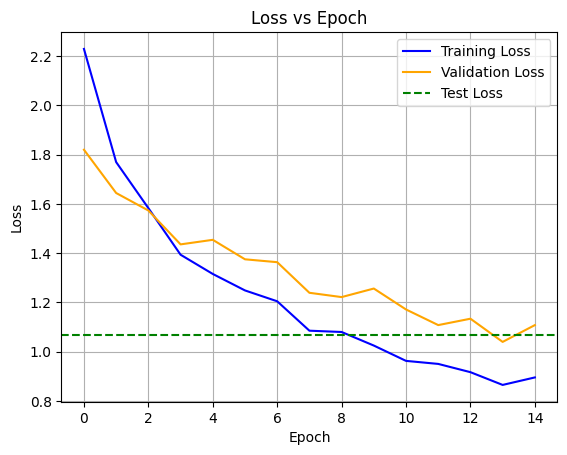

In [63]:
plt.plot(avg_losses, label='Training Loss', color='blue')  
plt.plot(val_losses, label='Validation Loss', color='orange')
plt.axhline(y=test_loss, color='green', linestyle='--', label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')
plt.grid(True)
plt.legend()
plt.show()

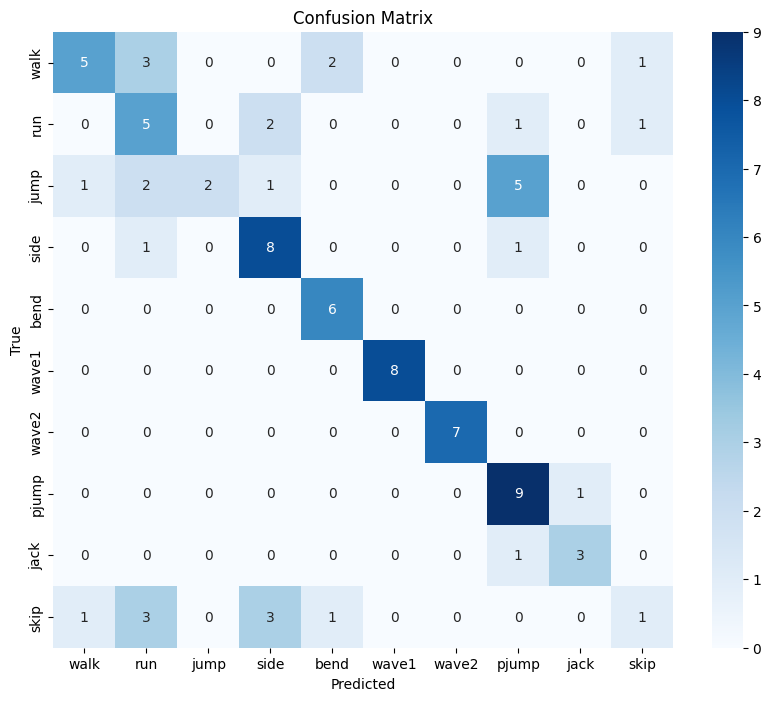

In [64]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(correct_labels, predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes.values(), yticklabels=classes.values())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Discussion
For multi-class classification, my model can correctly classify most examples, however performs worse comparsed to the greyscale model. The confusion matrix above summarises the models predictions.  
Most failure cases derive from the running as well as the pjump motions. Since the optical flows of the run, walk, side and skip motions are very similar, it would follow that the models struggles correctly predict these classes. 

Another failure case is in the pjump action, here the model has most likely learned that pjump is associated with a vertically moving optical flow, and with subsequencing the horizontal  motion may have been lost. Since the model cannot determine the orientation of the person from the jumping sequence, then it is significantly more challenging to distinguish what action is being performed.

In conclusion, my model has successfully learned distinct features associated with each action, however the model has not yet successfully learned the nuances between similar actions, and struggles to correctly classify them. If the model was tasked to generalise with these more distinct actions the model would perform well, however I expect with limited data augmentation, a degree of confusion as shown by the confusion matrix, the model may not generalise well to data outwith the Weizmann dataset. 

## Future Work
I would experiment with using a two-stream convolutional network, which wasn't feasible due to memory limitations. In this network I would have one stream for processing the optical flows, whilst another network would process greyscale video. This would mitigate issues related to the optical flow being too noisy or ambiguous to distinguish between particular actions. I would also invesitgate using more convolutional layers and a larger batch size to see if the model could learn these nuances.

It is possible that applying frame-skipping, or obtaining single frames at the data augmentation stage would help the model learn nuances, however I do not have the time to experiment with this.

Furthermore, with a stronger GPU I would build a larger dataset by creating more subsequences, by creating five more subsequences for each video training times become much longer. This would help the model correctly classify shorter video sequences.

In [ ]:
def classify(video):
    # Convert the video to optical flow
    video = dataset.calculate_optical_flow(video)
    model = GRU(num_classes=10)
    model.load_state_dict(torch.load('model.pth'))
    model.eval()
    prediction = model(video)
    return prediction